In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch
import argparse, json, glob, os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ipywidgets import interact, widgets, fixed

import sys, glob, os, imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import helper.canon_supervised_dataset as dset
import helper.post_processing as pp
import helper.utils as ut
import matplotlib
from skimage import exposure
matplotlib.rcParams.update({'font.size': 22})

import cv2

C:\Users\Harish\AppData\Local\Temp\ipykernel_63676\2314464860.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [155]:
def load_video_seq(folder_name, seq_id, start_ind, num_to_load):
    base_name_seq = os.path.join(folder_name, 'seq' + str(seq_id)) # folder_name + 'seq' + str(seq_id) + '/'

    # filepaths_all = glob.glob(base_name_seq + '*.mat')
    filepaths_all = glob.glob(os.path.join(base_name_seq, '*.mat'))
    filepaths_all = [filepath.replace('\\', '/') for filepath in filepaths_all] # for windows machines
    total_num = len(filepaths_all)
    ind = []
    for i in range(0,len(filepaths_all)):
        ind.append(int(filepaths_all[i].split('/')[-1].split('.')[0]))
    ind = np.argsort(np.array(ind))
    filepaths_all_sorted = np.array(filepaths_all)[ind]

    if num_to_load == 'all':
        num_to_load = total_num
        print('loading ', num_to_load, 'frames')
    full_im = np.empty((num_to_load, 640, 1080, 4))
    for i in range(0,num_to_load):
        loaded = scipy.io.loadmat(filepaths_all_sorted[start_ind +i])
        full_im[i] = loaded['noisy_list'].astype('float32')/2**16

    return full_im


def run_denoiser(sample, args_list, models_to_test, device):
    i=0
    with torch.no_grad():
            net_input = sample['noisy_input'].to(device)
            print(net_input.shape)
            if args_list[i].network == 'hrnet2d':
                    szo = net_input.shape
                    net_output = models_to_test[i](net_input.to(device).reshape(szo[0],szo[1]*szo[2],szo[3],szo[4])).reshape(szo)
            elif args_list[i].network =='dvdnet' or args_list[i].network =='dvdhr':
                net_output = torch.zeros_like(net_input[:,:,2:-3])
                for j in range(2,sample['noisy_input'].shape[2]-3):
                    net_input = sample['noisy_input'].to(device)
                    curr_ind = j
                    net_output[:,:,j-2] = models_to_test[i](net_input[:,:,curr_ind-2:curr_ind+3].to(device))
            else:
                net_output = models_to_test[i](net_input.to(device))

            out_plt = net_output.cpu().detach().numpy()[0].transpose(1,2,3,0)

    return out_plt


def load_video(video_path, start_ind, num_to_load, center_crop=256, target_size=256):
    full_im = np.zeros((num_to_load, target_size, target_size, 4))
    
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print('Total frame in video', total_frames)
    frame_ind = -1
    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame = frame[:, :int(frame.shape[1]//2)]

        height, width = frame.shape[:2]
        frame_ind += 1
        if frame_ind < start_ind:
            continue
        elif frame_ind >= (start_ind + num_to_load):
            break

        canvas = np.zeros((frame.shape[0], frame.shape[1], 4), dtype=np.uint8)
        canvas[:,:,0:3] = frame
        cropped_frame = canvas[int((height-center_crop)/2):int((height-center_crop)/2)+center_crop, int((width-center_crop)/2):int((width-center_crop)/2)+center_crop]
        
        if center_crop != target_size:
            full_im[frame_ind-start_ind, :, :, :3] = cv2.resize(cropped_frame[...,:3], (target_size, target_size)).astype('float32')/255
        else:
            full_im[frame_ind-start_ind] = cropped_frame.astype('float32')/255
    print('Loaded', full_im.shape[0], 'frames')
    return full_im


# Video denoising in starlight example
In this notebook, we load in our pretrained denoiser and denoise video sequences from our submillilux dataset. You can use this notebook to explore the dataset and check out the denoiser performance on a variety of scenes. 

## Load in saved model

In [144]:
base_folder = 'saved_models/'

chkp_path = 'dvdhr_semidar_noise_256_L1_LP2D_semidark-lowlight-only_gamma_linear_lowlight-only_additional-noise'
args5, model5 = ut.load_from_checkpoint(base_folder + chkp_path, best=False)

loading from checkpoint
loading FastDVDnet HR
['saved_models/dvdhr_semidar_noise_256_L1_LP2D_semidark-lowlight-only_gamma_linear_lowlight-only_additional-noise\\checkpoint100_test_loss0.18709_trainloss0.0896.pt', 'saved_models/dvdhr_semidar_noise_256_L1_LP2D_semidark-lowlight-only_gamma_linear_lowlight-only_additional-noise\\checkpoint120_test_loss0.29139_trainloss0.0877.pt']
distributed
resuming from checkoint, epoch: 0


In [145]:
list_of_files = glob.glob(base_folder + chkp_path + '/checkpoint*.pt')
latest_file = max(list_of_files, key=os.path.getctime)

In [146]:
latest_file

'saved_models/dvdhr_semidar_noise_256_L1_LP2D_semidark-lowlight-only_gamma_linear_lowlight-only_additional-noise\\checkpoint120_test_loss0.29139_trainloss0.0877.pt'

## Load in video clip
You can load in a video clip from our full dataset (92GB), or from our condensed dataset (only a few short clips, 1.3GB). Choose which clip to use below, and make sure to update the `folder_name` to match the location of your dataset. By default, we load in 16 images at a time, but you can load in more or fewer by changing `num_to_load`, as well as `start_ind` to refer to which frame of the video to start with (only relevant if using the full dataset).

A brief description of the videos from the condensed dataset are summarized below. The full description can be found [here](https://drive.google.com/drive/folders/1KFXAoJ8Hbtfb7g-WPex-rt8dJsbqZ7sk?usp=sharing).

|ID | Description| 
| --- | --- |
|43 | Two people sitting in chairs, drinking tea, and stargazing|
|8|Person playing volleyball|
|10|Umbrella spinning (shooting star)|
|7|Person with flowers close by|
|21|Flags waving in the wind (shooting star)|
|32|Person dancing with scarf|
|13|3 people dancing the macarena|
|5|Group of people walking around |
|6|Person dancing with flowers far away.|
|24|Swing dancing|
|26|Two people clapping hands|
|40|Person dancing with umbrella|


In [156]:
# seq_id = 1
# folder_name = 'data/denoised/'
# seq_id = 1
# folder_name = 'data/no-light-raw/'
# seq_id = 1
# folder_name = 'data/no-light-denoised/'
# seq_id = 43
# folder_name = 'data/starlight_dataset_condensed/'
# seq_id = 1
# folder_name = 'data/mobile-light-rgb-thermal/'
# seq_id = 1
# folder_name = 'data/no-light-rgb-thermal/'

# start_ind = 0
# num_to_load = 'all' # 16 # 'all' 
# noisy_video = load_video_seq(folder_name, seq_id, start_ind, num_to_load)

seq_id = 1
video_path = r"C:\projects\DeepHeat\low-light\data_collection\data\lowlight-darkenhance-pixelbinning-lace-masi-videos\semi-dark-1.avi"
start_ind = 1800
num_to_load = 600 # 16 # 'all' 
noisy_video = load_video(video_path, start_ind, num_to_load, center_crop=512, target_size=256)

Total frame in video 3445
Loaded 600 frames


In [157]:
print(noisy_video[0].shape)

noisy_video.max(), noisy_video.min()

(256, 256, 4)


(0.7176470756530762, 0.0)

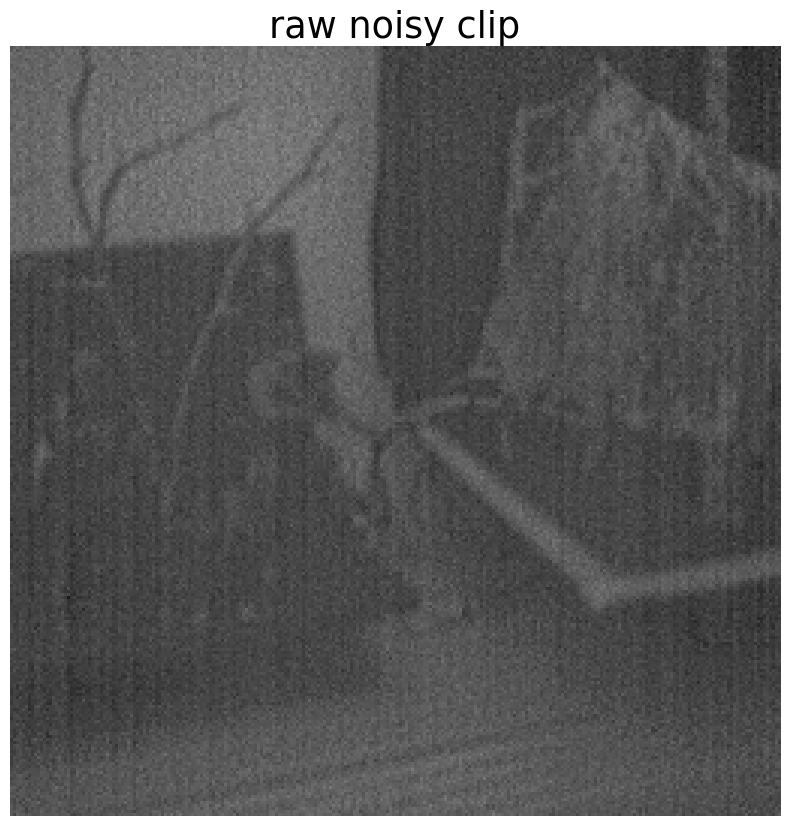

In [158]:
ind = 0
plt.figure(figsize = (20,10))
plt.imshow(noisy_video[ind][...,0:3]); 
plt.axis('off');
plt.title('raw noisy clip');

In [159]:
noisy_video.shape

# noisy_video[10, :, :, 0]
# noisy_video[10, :, :, 0].max(), noisy_video[10, :, :, 0].min()

(600, 256, 256, 4)

In [160]:
type(noisy_video)

numpy.ndarray

In [161]:
if noisy_video.shape[0] == 1:
    noisy_video = noisy_video.repeat(10, axis=0)
    print('Converted to shape', noisy_video.shape)

In [162]:
# ut.plt3D(noisy_video)

(256, 256, 3)
0.5568627715110779 0.0941176488995552


c:\Users\Harish\miniconda3\envs\starlight\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


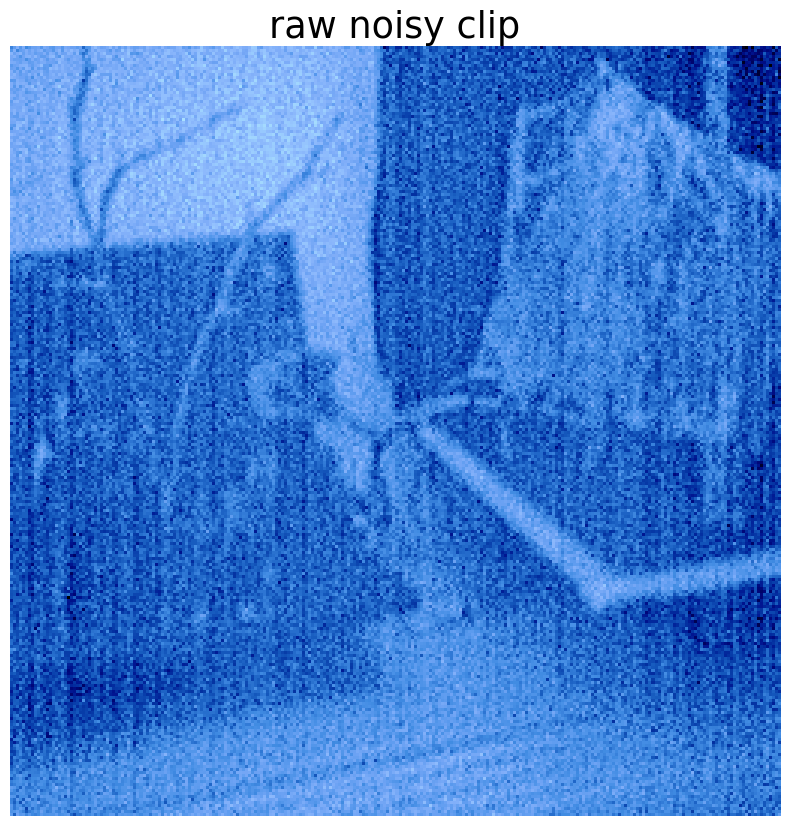

In [163]:
ind = 0
print(noisy_video[ind][...,0:3].shape)
print(noisy_video[ind][...,0:3].max(), noisy_video[ind][...,0:3].min())
plt.figure(figsize = (20,10))
plt.imshow(exposure.equalize_hist(pp.process(noisy_video[ind][...,0:3], [pp.white_balance, pp.clip,pp.gamma]))); 
# plt.imshow(exposure.equalize_hist(pp.process(noisy_video[ind][...,0:3], []))); 
plt.axis('off');
plt.title('raw noisy clip');

## Denoise video sequence

In [164]:
tt = dset.ToTensor()
sample = {'noisy_input': noisy_video}
sample = tt(sample)

args_list = [args5]
models_to_test = [model5]
device = 'cuda:0'

converting to tensor
done converting to tensor


### On 256 crop

In [165]:
# out_plt = ut.run_denoiser(sample, args_list, models_to_test, device)
out_plt = run_denoiser(sample, args_list, models_to_test, device)


torch.Size([1, 4, 600, 256, 256])


### On 512 crop

In [125]:
out_plt = np.zeros([num_to_load-5, 512, 512, 4])

for h_idx in [0, 256]:
    for w_idx in [0, 256]:
        sample = {'noisy_input': noisy_video[:, h_idx:h_idx+256, w_idx:w_idx+256, :]}
        print('H', h_idx, h_idx+256, 'W', w_idx, w_idx+256)
        sample = tt(sample)
        out_plt[:, h_idx:h_idx+256, w_idx:w_idx+256] = run_denoiser(sample, args_list, models_to_test, device)

H 0 256 W 0 256
converting to tensor
done converting to tensor
torch.Size([1, 4, 600, 256, 256])
H 0 256 W 256 512
converting to tensor
done converting to tensor
torch.Size([1, 4, 600, 256, 256])
H 256 512 W 0 256
converting to tensor
done converting to tensor
torch.Size([1, 4, 600, 256, 256])
H 256 512 W 256 512
converting to tensor
done converting to tensor
torch.Size([1, 4, 600, 256, 256])


In [112]:
print(out_plt.shape)
print(type(out_plt))

(11, 512, 512, 4)
<class 'numpy.ndarray'>


C:\Users\Harish\AppData\Local\Temp\ipykernel_63676\1920634380.py:4: RuntimeWarning: invalid value encountered in power
  im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])


(-0.5, 511.5, 511.5, -0.5)

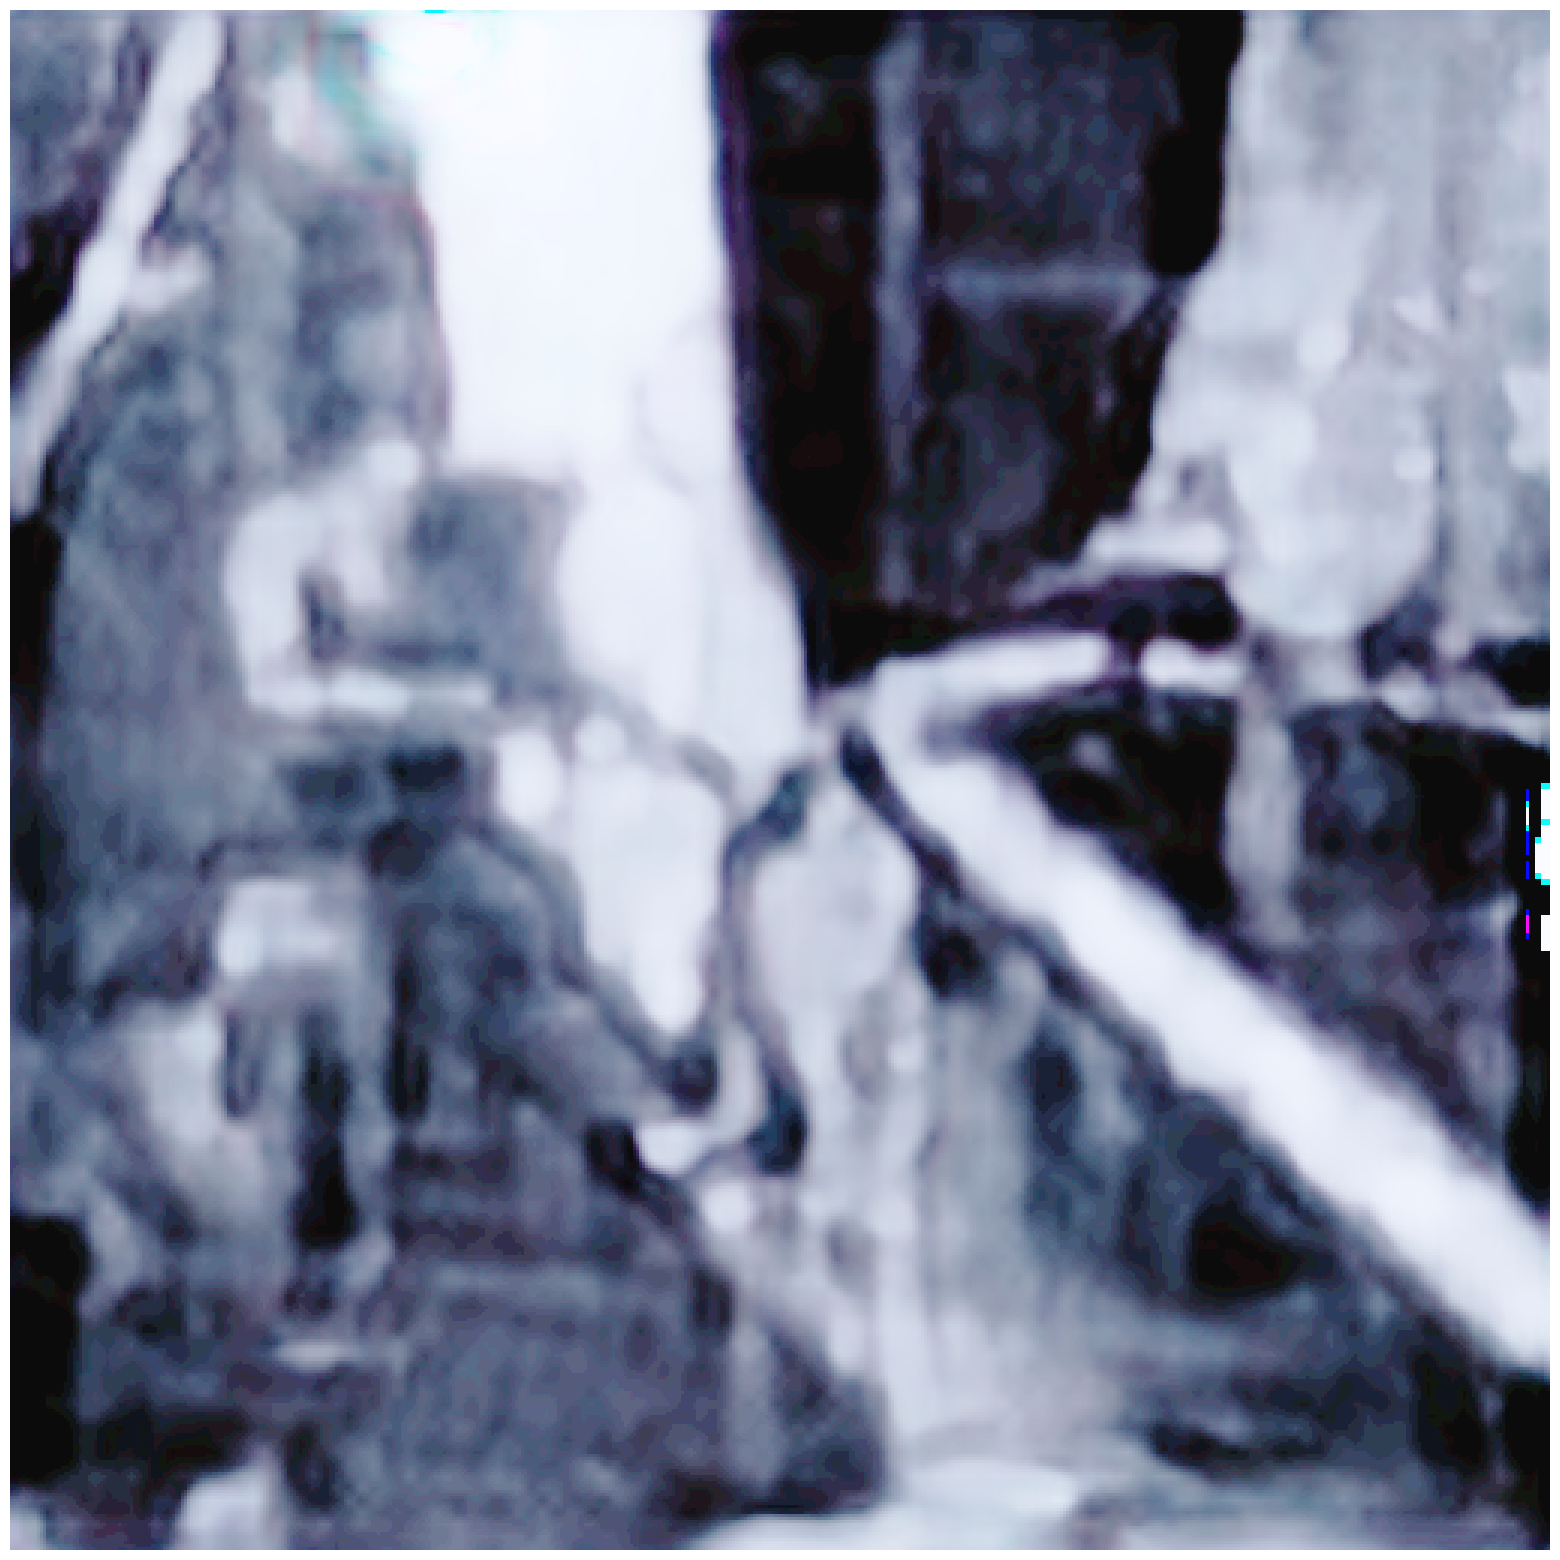

In [88]:
ind = 0
plt.figure(figsize = (20,20))
# im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
if seq_id not in [21, 26, 22]:
    im_ours = exposure.equalize_hist(im_ours)

plt.imshow(im_ours[:,:]);
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

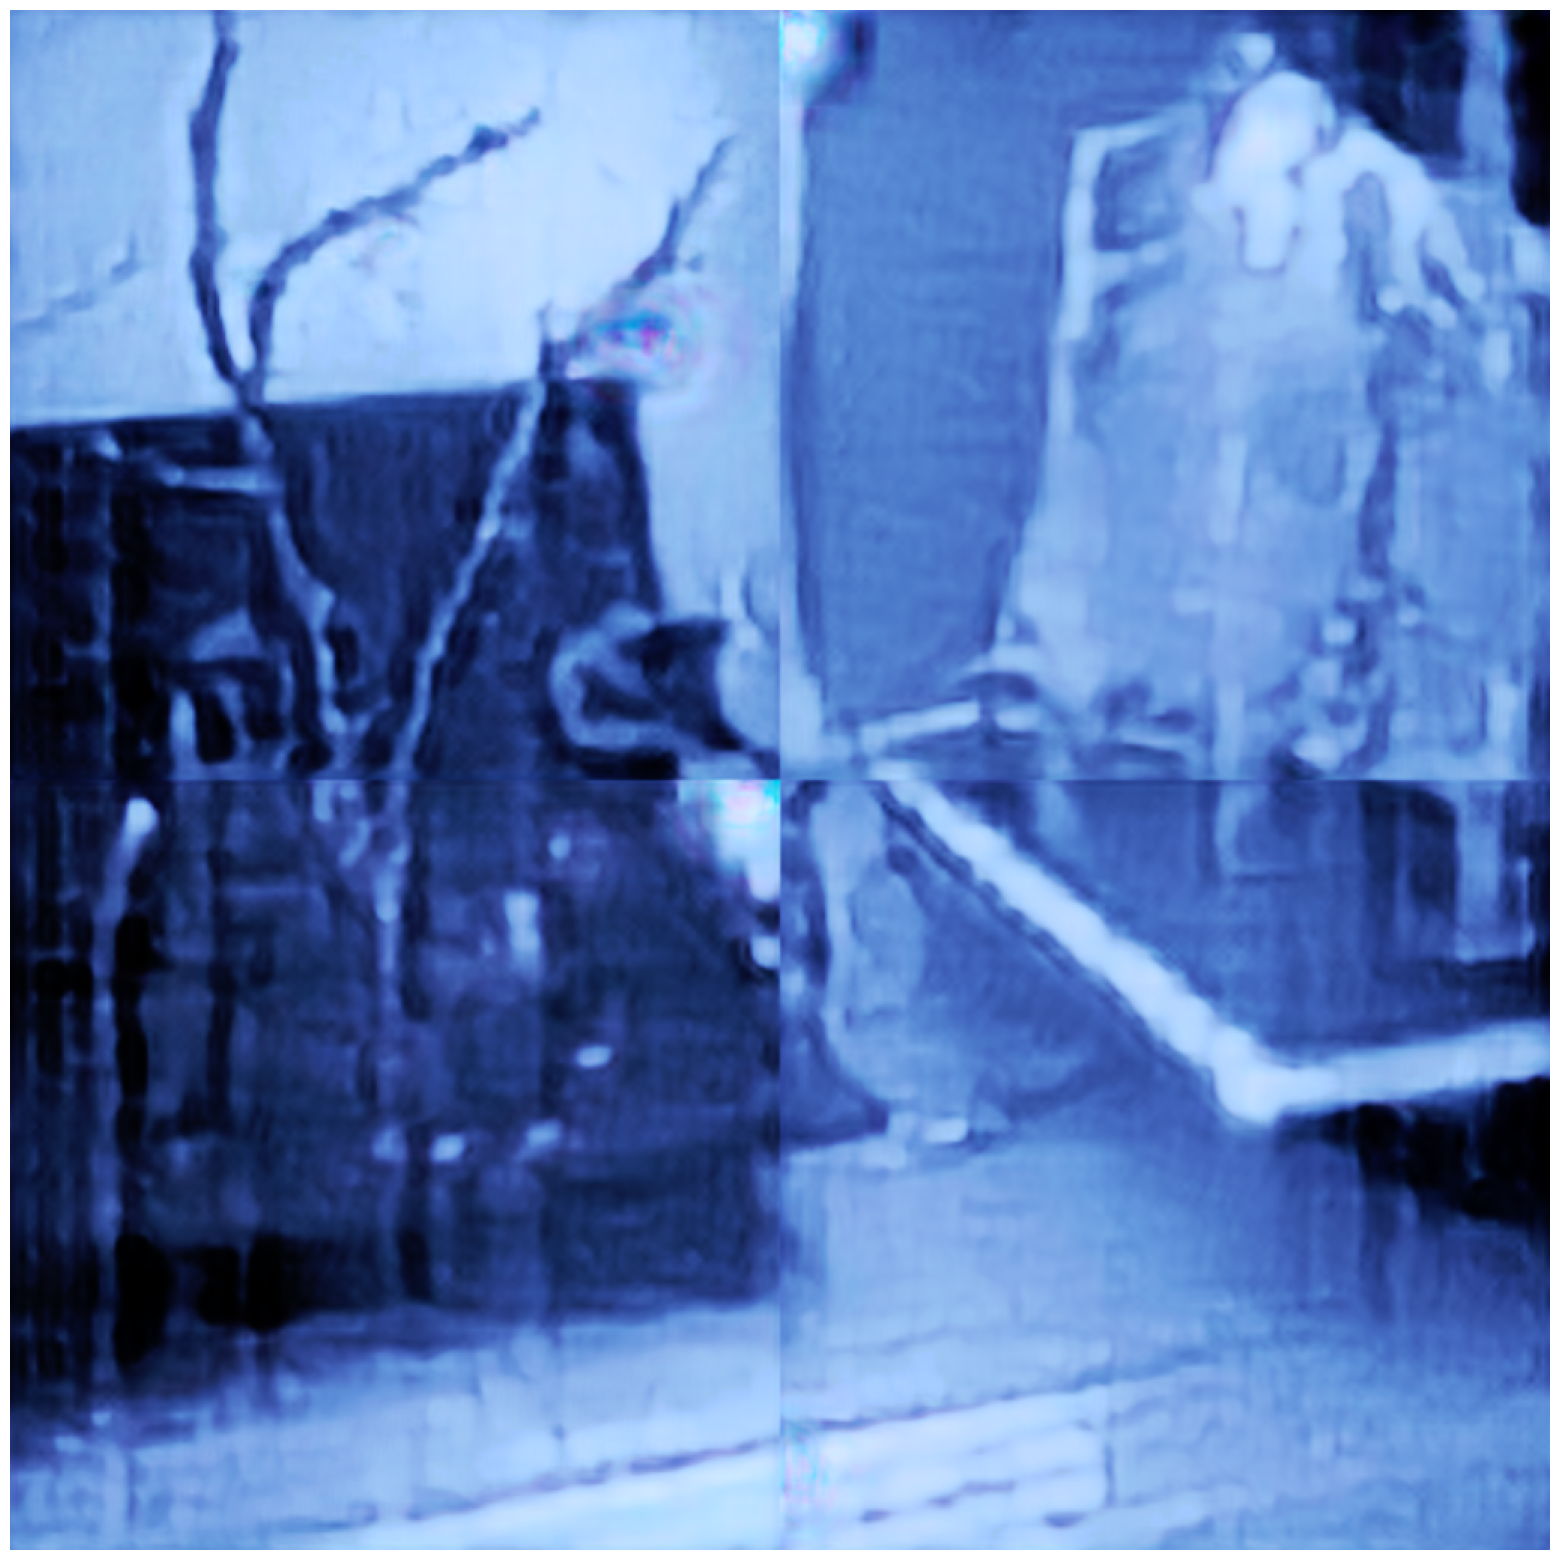

In [126]:
ind = 3
plt.figure(figsize = (20,20))
# im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
im_ours = pp.process(out_plt[ind], [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
if seq_id not in [21, 26, 22]:
    im_ours = exposure.equalize_hist(im_ours)

plt.imshow(im_ours[:,:]);
plt.axis('off')

C:\Users\Harish\AppData\Local\Temp\ipykernel_63676\2018253566.py:3: RuntimeWarning: invalid value encountered in power
  im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])


(-0.5, 1023.5, 1023.5, -0.5)

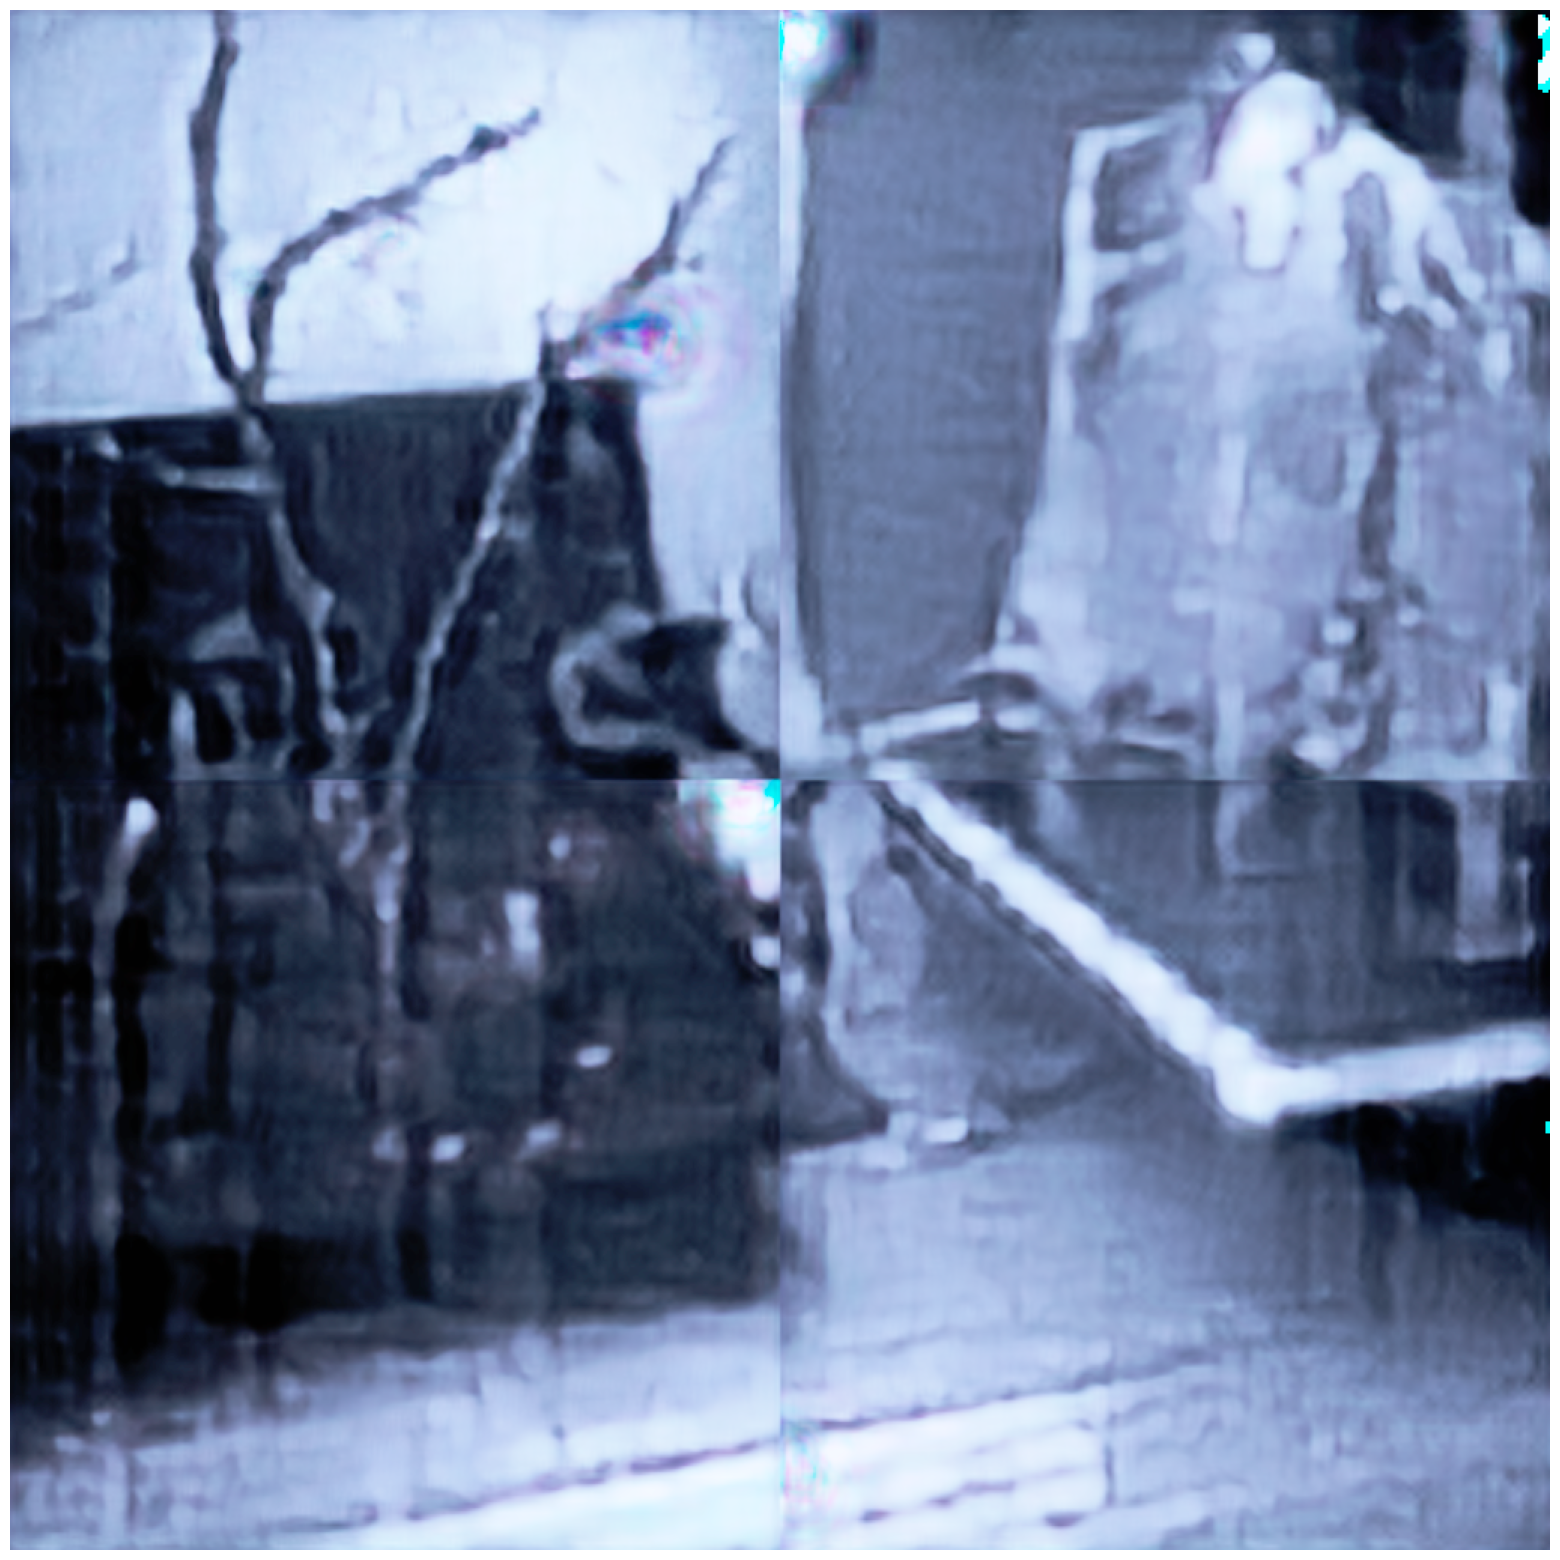

In [127]:
ind = 3
plt.figure(figsize = (20,20))
im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
if seq_id not in [21, 26, 22]:
    im_ours = exposure.equalize_hist(im_ours)

plt.imshow(im_ours[:,:]);
plt.axis('off')

In [166]:
im_video = np.empty_like(out_plt[...,0:3])
for i in range(0, out_plt.shape[0]):
    im_video[i] = pp.process(out_plt[i], [pp.white_balance, pp.clip,pp.gamma])
    if seq_id not in [21, 26]:
        im_video[i] = exposure.equalize_hist(im_video[i])

In [167]:
ut.plt3D(np.clip(im_video[:,:,:,0:3],0,1))

interactive(children=(IntSlider(value=1, description='r', max=594), Output()), _dom_classes=('widget-interact'…

In [168]:
noisy_video_equalized = np.zeros_like(noisy_video)
noisy_video_equalized = noisy_video_equalized[..., 0:3]

for i in range(0, noisy_video.shape[0]):
    noisy_video_equalized[i] = pp.process(noisy_video[i], [pp.white_balance, pp.clip, pp.gamma])
    if seq_id not in [21, 26]:
        noisy_video_equalized[i] = exposure.equalize_hist(noisy_video_equalized[i])

In [169]:
ut.plt3D(np.clip(noisy_video_equalized[:,:,:,0:3],0,1))

interactive(children=(IntSlider(value=1, description='r', max=599), Output()), _dom_classes=('widget-interact'…

In [170]:
noisy_video_equalized.shape
im_video.shape

ut.plt3D(np.clip(np.concatenate([noisy_video_equalized[5:], im_video], axis=2)[:,:,:,0:3],0,1))


interactive(children=(IntSlider(value=1, description='r', max=594), Output()), _dom_classes=('widget-interact'…

In [171]:
input_and_output = np.clip(np.concatenate([noisy_video_equalized[5:], im_video], axis=2)[:,:,:,0:3],0,1)

## Save video clip as gif

In [172]:
if not os.path.exists('saved_videos/'):
    os.mkdir('saved_videos/')
images = []
for i in range(0,input_and_output.shape[0]):
    images.append((input_and_output[i]*255).astype('uint8'))
imageio.mimsave('saved_videos/' + str(seq_id) + '_denoised.gif', images)